In [1]:
import sys 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

sys.path.insert(1, "/home/paperspace/devinterp") # TODO fix path

from devinterp.slt.sampler import Sampler, SamplerConfig, estimate_rlct

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"



In [2]:
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)

def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)

# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [3]:
DEVICE = 'cuda'
# Load MNIST data
train_data = datasets.MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
# Load test data
test_data = datasets.MNIST('./data', train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)
# Initialize model, loss, optimizer and sgld sampler
model = Net().to(DEVICE)
criterion = nn.CrossEntropyLoss()
lr = 5e-3
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0.01)
n_epochs = 40


In [4]:
# train model
if False:
    train_losses = []
    test_losses = []
    rlct_estimates = []
    models = []
    for epoch in range(n_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        test_loss = evaluate(model, test_loader, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        # rlct_estimates.append(rlct_estimate)
        models += [copy.deepcopy(model)]
        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")
    torch.save(models, 'models_NONOwd.pth')

a
834.2474975585938 3333.694580078125
a
786.9313354492188 3564.230712890625
a
1146.01171875 1417.258056640625
a
123.93584442138672 2671.45849609375
a
565.6162109375 1453.20361328125
a
12.659072875976562 2955.236083984375
a
400.1958312988281 4142.48681640625
a
1217.91162109375 3339.58154296875
a
-764.6091918945312 2830.08984375
a
539.7147827148438 2150.547607421875
a
1257.102294921875 2886.52734375
a
759.2815551757812 2696.004150390625
a
508.9901428222656 3617.71533203125
a
10.480722427368164 2461.7431640625
a
-856.6494140625 3650.06494140625
a
781.2728271484375 2950.212646484375
a
54.86735916137695 2915.795166015625
a
-331.99700927734375 2879.80078125
a
500.0731201171875 3945.947265625
a
881.5577392578125 1994.9984130859375
a
1068.8880615234375 4705.59228515625
a
855.9774169921875 2638.41015625
a
-128.04339599609375 2644.215087890625
a
827.891845703125 2021.9813232421875
a
-188.71005249023438 3502.50048828125
a
1280.584716796875 3195.28125
a
421.33001708984375 4014.320556640625
a
-562.

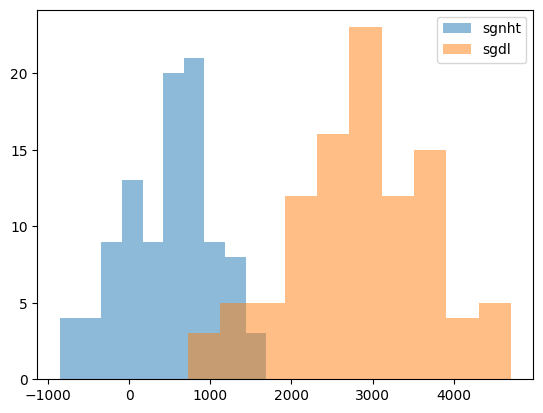

NameError: name 'train_losses' is not defined

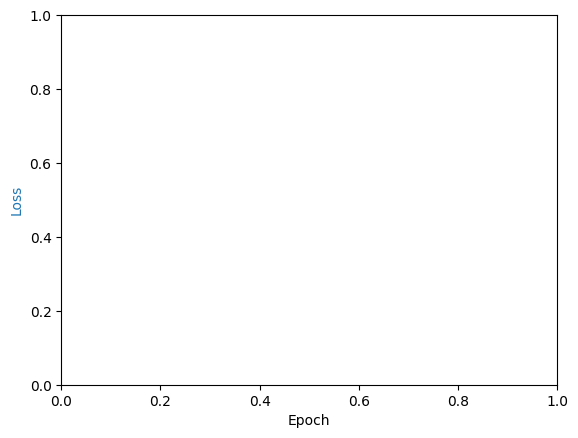

In [8]:
from devinterp.slt.sampler import Sampler, SamplerConfig, estimate_rlct
# todo boundary box depence
# Load MNIST data
train_data = datasets.MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
# Load test data
test_data = datasets.MNIST('./data', train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)
# Initialize sgnht sampler
SGNHT_config = SamplerConfig(
    optimizer_config=dict(
        optimizer_type="SGNHT",
        lr=5e-5,
        diffusion_factor=0.1,
        # bounding_box_size=,
        num_samples=len(train_data),
        batch_size = 32
    ),
    num_chains=4,
    num_draws_per_chain=200,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    verbose=False,
    batch_size=32,         
    criterion = 'cross_entropy' # alternatives: mse
)
SGLD_config = SamplerConfig(
    optimizer_config=dict(
        optimizer_type="SGLD",
        lr=5e-5,
        noise_level=0.1,
        weight_decay=1e-6,
        elasticity=50000.,
        temperature='adaptive',
        num_samples=len(train_data),
    ),
    num_chains=4,
    num_draws_per_chain=200,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    verbose=False,
    batch_size=32,         
    criterion = 'cross_entropy' # alternatives: mse
)

models = torch.load('models_NONOwd.pth')
rlct_estimates_sgnht = []
rlct_estimates_sgdl = []
for n in range(100):
    model = copy.deepcopy(models[-1].to('cpu'))
    sgnht_sampler = Sampler(model, train_data, SGNHT_config)
    model = copy.deepcopy(models[-1].to('cpu'))
    sgdl_sampler = Sampler(model, train_data, SGLD_config)
    model = copy.deepcopy(models[-1].to('cpu'))

    rlct_estimate_sgnht = sgnht_sampler.sample(summary_fn=estimate_rlct)
    print('a')
    model = copy.deepcopy(models[-1].to('cpu'))
    rlct_estimate_sgdl = sgdl_sampler.sample(summary_fn=estimate_rlct)
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgdl += [rlct_estimate_sgdl]
    print(rlct_estimate_sgnht, rlct_estimate_sgdl)
plt.hist(rlct_estimates_sgnht,alpha = 0.5, label='sgnht')
plt.hist(rlct_estimates_sgdl,alpha = 0.5, label='sgdl')
plt.legend()
plt.show()
# Plotting
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(train_losses, label='Train Loss', color='tab:blue')
ax1.plot(test_losses, label='Test Loss', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx() 
ax2.set_ylabel('rlct_estimate', color='tab:green')
ax2.plot(rlct_estimates, label='rlct_estimate', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()